In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function
import itertools
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn import model_selection
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn_pandas import gen_features
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
scores = pd.read_csv('soretdScores.csv', lineterminator='\n')
data = pd.read_csv('motionData.csv', lineterminator='\n')
data.rename(columns={"FFPType\r": "FFPType"},inplace=True)

In [3]:
FEATURES = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"]
FEATURESALL = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType"]
FEATURESALL_WTS = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType", "happier_wt", "sadder_wt", "angrier_wt", "more-afraid_wt"]

In [4]:
EMOSCORES = ["happier_mu", "sadder_mu", "angrier_mu", "more-afraid_mu"]
EMOCONFIDENCE_INV = ["happier_sigma", "sadder_sigma", "angrier_sigma", "more-afraid_sigma"]
min_confidence = 25/3 # true skill base confidence: http://trueskill.org/
WTS_LABEL = ["happier_wt", "sadder_wt", "angrier_wt", "more-afraid_wt"]

In [5]:
mapperLR = DataFrameMapper([
...     (["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"], preprocessing.StandardScaler()),
...     (['FFPType'], preprocessing.OneHotEncoder())], input_df = True, sparse = True)

In [6]:
WTS= {'happier_wt':(1.0-(scores[EMOCONFIDENCE_INV[0]]/min_confidence)).values,
                   'sadder_wt':(1.0-(scores[EMOCONFIDENCE_INV[1]]/min_confidence)).values,
                'angrier_wt':(1.0-(scores[EMOCONFIDENCE_INV[2]]/min_confidence)).values,
      'more-afraid_wt':(1.0-(scores[EMOCONFIDENCE_INV[3]]/min_confidence)).values}
WTS_df = pd.DataFrame(WTS,scores.index)

In [7]:
model_dir_name = "/Users/rutad/Documents/bitbucket/pythonTF/SVRBaseline"

Populating the interactive namespace from numpy and matplotlib


C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


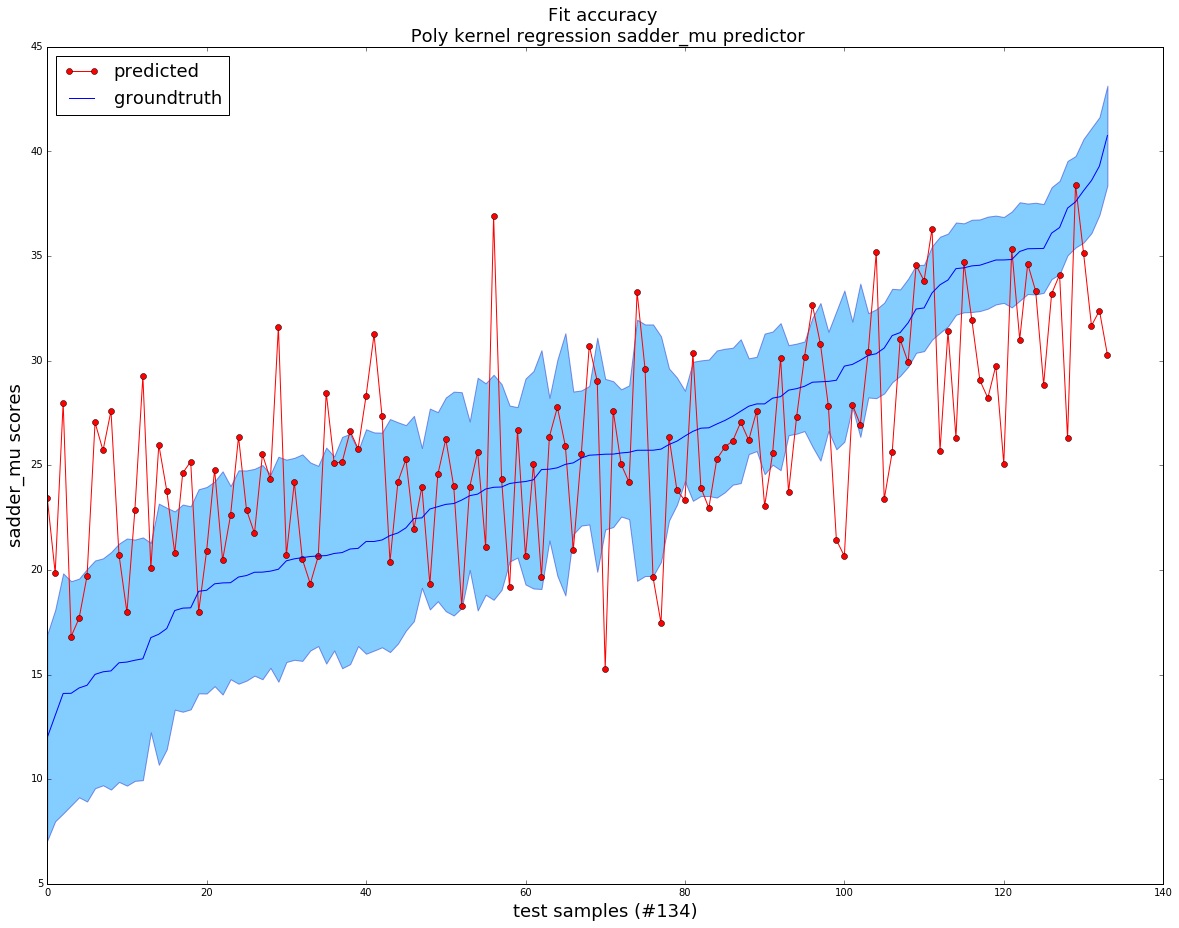

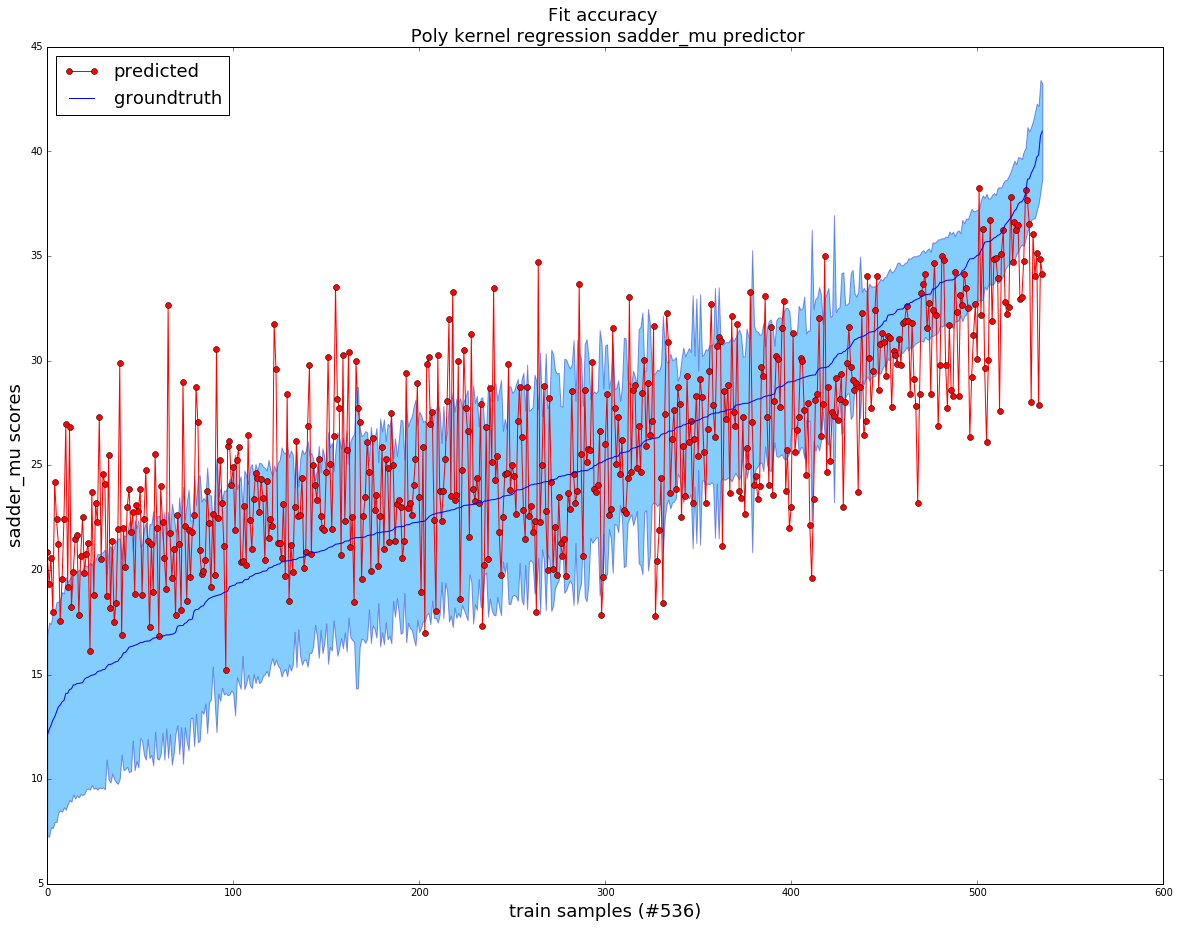

Populating the interactive namespace from numpy and matplotlib


C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


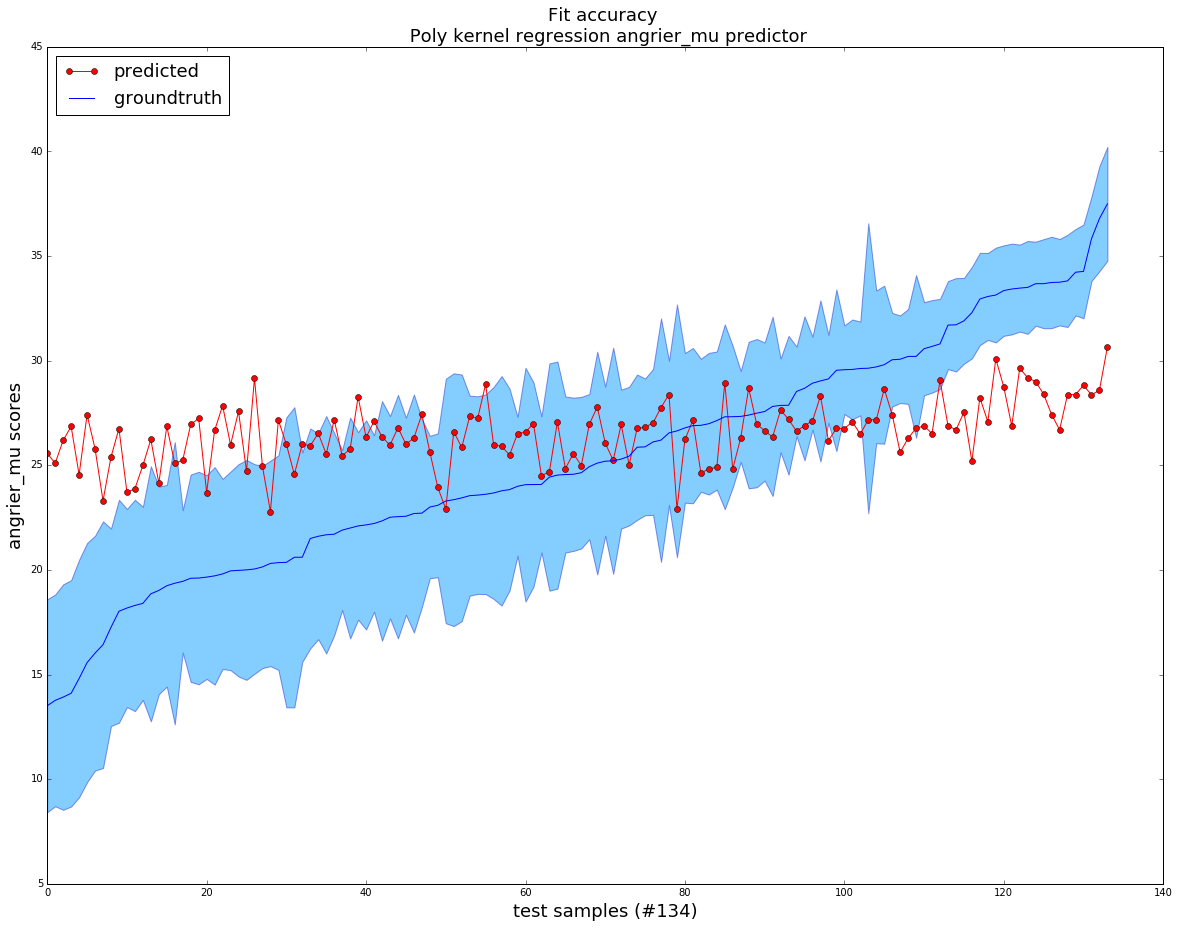

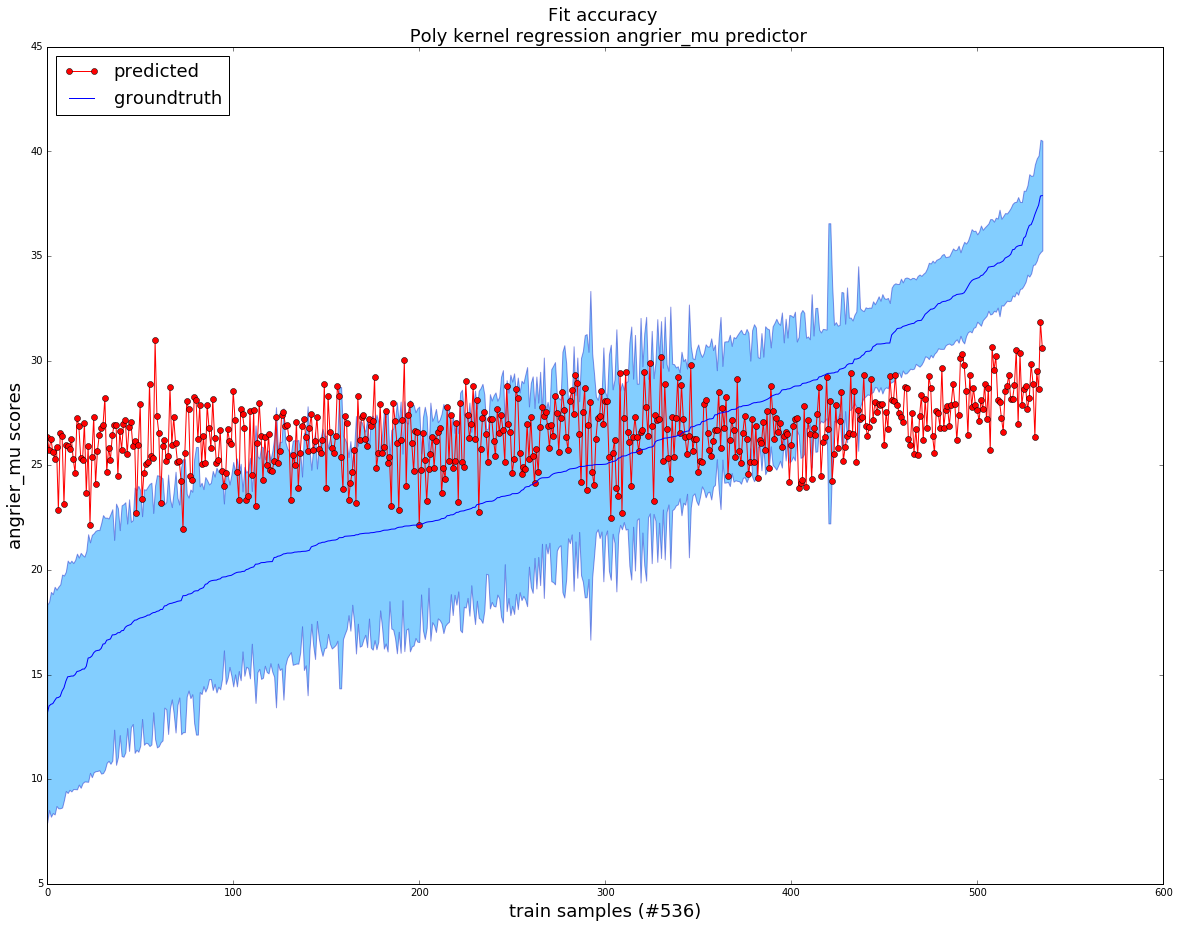

Populating the interactive namespace from numpy and matplotlib


C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


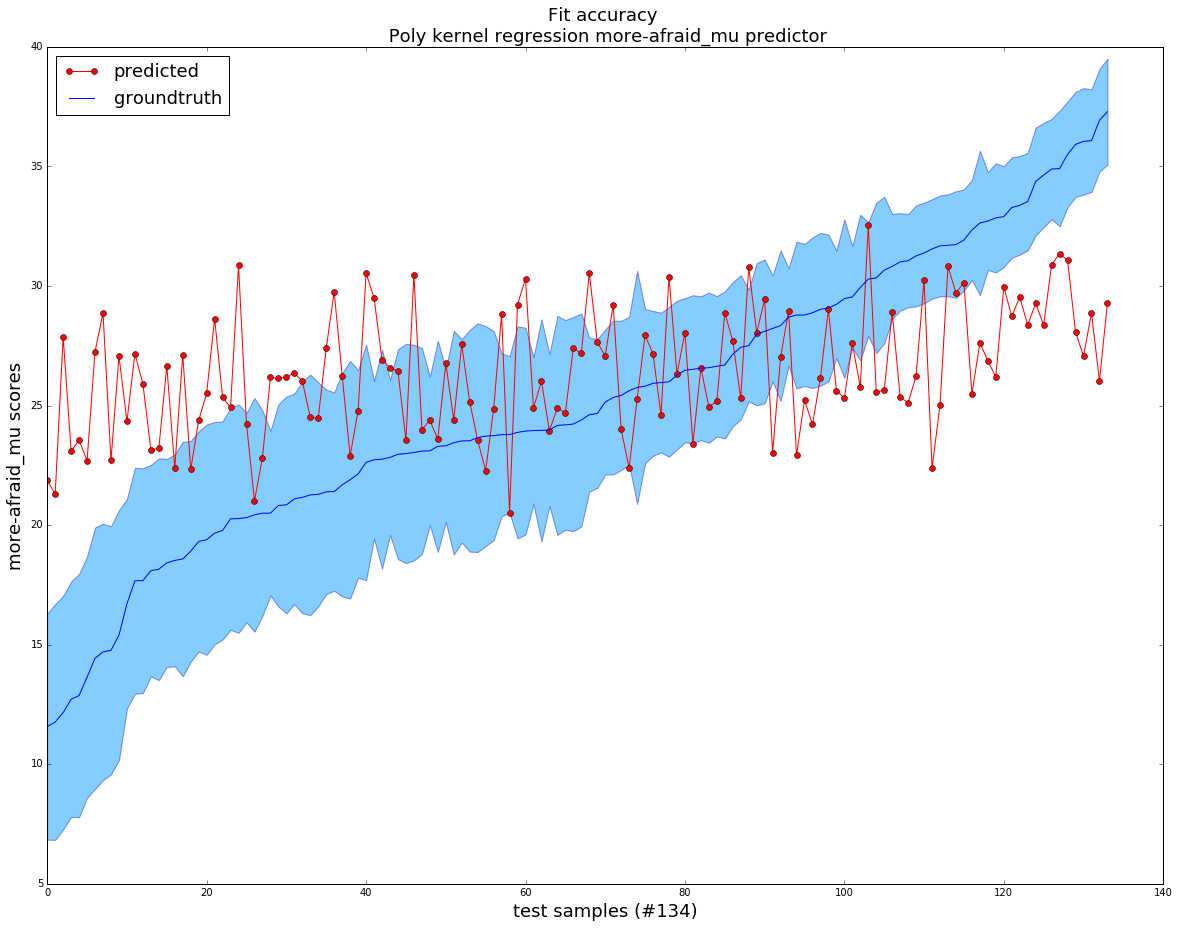

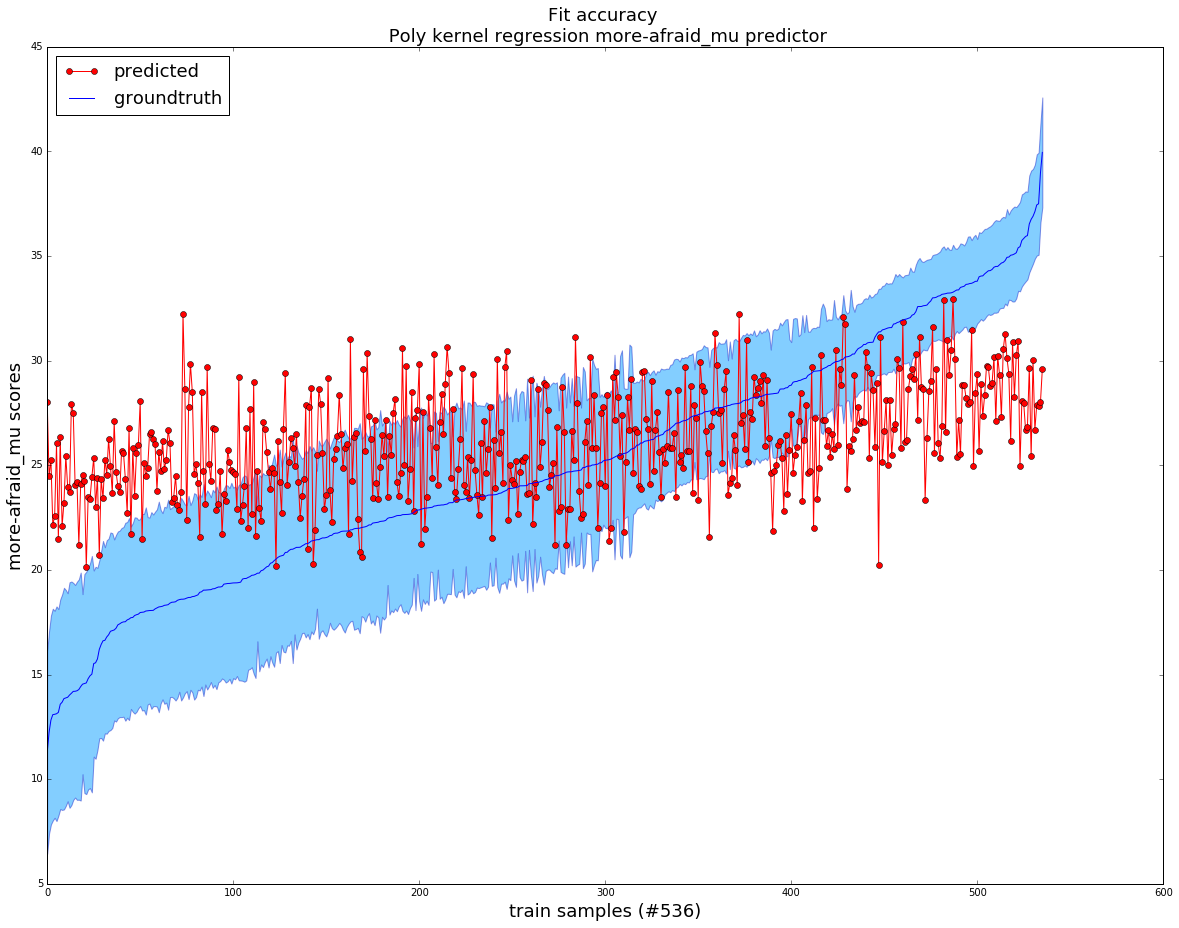

In [11]:
transformedDataLR = mapperLR.fit_transform(data.copy())

scores_WTS = pd.concat([scores, WTS_df], axis = 1)

X_trainLR, X_testLR, y_trainLR, y_testLR = model_selection.train_test_split(transformedDataLR, scores_WTS, test_size=0.2, random_state=42)


for i in range (1,4):
    LABEL_ID = i;
    LABEL = EMOSCORES[LABEL_ID]
    WT_COL = WTS_LABEL[LABEL_ID]
    predicted_name ="predicted_"+LABEL
    predicted_name_train ="predicted_"+LABEL+"_train"
    
    svr = GridSearchCV(SVR(kernel='poly', gamma=0.1, epsilon = 1.0), cv=5,
                  param_grid={"kernel":['linear','poly','rbf','sigmoid'],
                              #"C":[3,2,1e0, 0.1,0.01],
                              #"epsilon": [3,2,1e0, 0.1,0.01],
                              "gamma": np.logspace(-2, 2, 5),
                              "degree": [2,3,4],
                              "coef0": [10, 1e0, 0.1, 1e-2]})
    
    svr.fit(X_trainLR, y_trainLR[EMOSCORES[LABEL_ID]],sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]])

    ytest_pred_lr=svr.predict(X_testLR)
    ytrain_pred_lr=svr.predict(X_trainLR)
    
    testmse = metrics.mean_squared_error(y_testLR[EMOSCORES[LABEL_ID]],ytest_pred_lr,sample_weight=y_testLR[WTS_LABEL[LABEL_ID]])
    testr2 = metrics.r2_score( y_testLR[EMOSCORES[LABEL_ID]],ytest_pred_lr,sample_weight=y_testLR[WTS_LABEL[LABEL_ID]])
    trainmse = metrics.mean_squared_error( y_trainLR[EMOSCORES[LABEL_ID]],ytrain_pred_lr,sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]])
    trainr2 = metrics.r2_score( y_trainLR[EMOSCORES[LABEL_ID]],ytrain_pred_lr,sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]])
    
    y_hat_lr = pd.DataFrame(ytest_pred_lr, columns=[predicted_name], index=y_testLR[LABEL].index) 
    y_all_testlr = pd.concat([y_hat_lr, y_testLR[LABEL], y_testLR[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
    y_all_testlr_sorted = y_all_testlr.sort_values(EMOSCORES[LABEL_ID],ascending=[True])
    ytrain_hat_lr = pd.DataFrame(ytrain_pred_lr, columns=[predicted_name_train], index=y_trainLR[LABEL].index) 
    y_all_trainlr = pd.concat([ytrain_hat_lr, y_trainLR[LABEL], y_trainLR[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
    y_all_trainlr_sorted = y_all_trainlr.sort_values(EMOSCORES[LABEL_ID],ascending=[True])
    
    %pylab inline
    pylab.rcParams['figure.figsize'] = (20, 15)
    ax =plt.figure()
    x = np.arange(0, y_all_testlr_sorted[predicted_name].size, 1)
    plt.errorbar(x,y_all_testlr_sorted[predicted_name].values,fmt='r-o',label="predicted")
    plt.fill_between(x, y_all_testlr_sorted[LABEL].values-y_all_testlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_testlr_sorted[LABEL].values+y_all_testlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]],
        alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
    plt.errorbar(x,y_all_testlr_sorted[LABEL].values,fmt='b',label="groundtruth")
    #plt.title(model_dir_name,fontsize=18)
    plt.title('Fit accuracy \n Poly kernel regression ' + LABEL + ' predictor',fontsize=18)
    plt.xlabel('test samples (#'+str(y_testLR[LABEL].size)+')',fontsize=18)
    plt.ylabel(LABEL +' scores',fontsize=18)
    pylab.legend(loc='upper left', fontsize=18)
    plt.show()
    fig_name = model_dir_name +"/" + LABEL+ "_SVRtestPrediction.pdf"
    ax.savefig(fig_name)
    
    pylab.rcParams['figure.figsize'] = (20, 15)
    ax =plt.figure()
    x = np.arange(0, y_all_trainlr_sorted[predicted_name_train].size, 1)
    plt.errorbar(x,y_all_trainlr_sorted[predicted_name_train].values,fmt='r-o',label="predicted")
    plt.fill_between(x, y_all_trainlr_sorted[LABEL].values-y_all_trainlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_trainlr_sorted[LABEL].values+y_all_trainlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]],
        alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
    plt.errorbar(x,y_all_trainlr_sorted[LABEL].values,fmt='b',label="groundtruth")
    #plt.title(model_dir_name,fontsize=18)
    plt.title('Fit accuracy \n Poly kernel regression ' + LABEL + ' predictor',fontsize=18)
    plt.xlabel('train samples (#'+str(y_trainLR[LABEL].size)+')',fontsize=18)
    plt.ylabel(LABEL +' scores',fontsize=18)
    pylab.legend(loc='upper left', fontsize=18)
    plt.show()
    fig_name = model_dir_name +"/" + LABEL+ "_SVRtrainPrediction.pdf"
    ax.savefig(fig_name)

    regr_info = pd.Series(str(svr.best_estimator_))
    save_info = pd.DataFrame(columns = ['regressor name','test wtd mse', 'test wtd r2', 'train wtd mse', 'train wtd r2', 'emotion'])
    save_info.loc[1]= [regr_info[0], testmse, testr2, trainmse, trainr2, LABEL]
    
    with open('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\SVRBaseline\\SVRBaselineExperiments.csv', 'a') as f:
        save_info.to_csv(f, header=False, index=False)